# MODELLING

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
import ds_charts as ds
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
import graphviz
import midstep_evaluation_functions as midfunc
from numpy import ndarray
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

%run p00_settings.ipynb

In [2]:
data_train = pd.read_csv(project_path + prepared_out_data_file_train, na_values='', sep=',')
data_test = pd.read_csv(project_path + prepared_out_data_file_test, na_values='', sep=',')

In [3]:
cat_vars_train = data_train.select_dtypes(include='object')
data_train[cat_vars_train.columns] = data_train.select_dtypes(['object']).apply(lambda x: x.astype('category'))

cat_vars_test = data_test.select_dtypes(include='object')
data_test[cat_vars_test.columns] = data_test.select_dtypes(['object']).apply(lambda x: x.astype('category'))

## 00 - Feature Engineering

### 00.1 - Feature Selection:

<b>Droping Redundant Variables</b>

Two variables are said to be redundant if they express the same information. So, from the modeling perspective they both has the same impact over the result. One of the ways to avoid redundancy is to find the set of pairs of correlated variables, and drop one of each pair.

In [4]:
def select_redundant(corr_mtx, threshold: float):
    if corr_mtx.empty:
        return {}

    corr_mtx = abs(corr_mtx)
    vars_2drop = {}
    for el in corr_mtx.columns:
        el_corr = (corr_mtx[el]).loc[corr_mtx[el] >= threshold]
        if len(el_corr) == 1:
            corr_mtx.drop(labels=el, axis=1, inplace=True)
            corr_mtx.drop(labels=el, axis=0, inplace=True)
        else:
            vars_2drop[el] = el_corr.index
    return vars_2drop, corr_mtx

In [5]:
data = pd.concat([data_train, data_test])

In [6]:
drop, corr_mtx = select_redundant(data.corr(), THRESHOLD)
print(drop.keys())

dict_keys([])


Afer identifying the pairs of correlated variables is then possible to analyse the correlation matrix, with focus on the variables with high correlations.

In [7]:
if corr_mtx.empty:
    raise ValueError('Matrix is empty.')

figure(figsize=[10, 10])
heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=False, cmap='Blues')
title('Filtered Correlation Analysis')
savefig(project_path + f'images/filtered_correlation_analysis_{THRESHOLD}.png')
show()

ValueError: Matrix is empty.

Now, we need to select only part of the correlated variables, in order to not loose information - per each pair of correlated variables, we can only drop one of them.

In [8]:
def drop_redundant(data: pd.DataFrame, vars_2drop: dict) -> pd.DataFrame:
    sel_2drop = []
    print(vars_2drop.keys())
    for key in vars_2drop.keys():
        if key not in sel_2drop:
            for r in vars_2drop[key]:
                if r != key and r not in sel_2drop:
                    sel_2drop.append(r)
    print('Variables to drop', sel_2drop)
    df = data.copy()
    for var in sel_2drop:
        df.drop(labels=var, axis=1, inplace=True)
    return df
    
if feat_sel:
    data_feat_sel = drop_redundant(data, drop)
else:
    data_feat_sel = data.copy()
    
data_feat_sel

dict_keys([])
Variables to drop []


,Unnamed: 0,latitude,longitude,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_total_usd,avg_participants,...,has_roundA,has_roundB,has_roundC,has_roundD,is_top500,founded_at,first_funding_at,last_funding_at,status,closed_at
0,1.174855,-0.301800,-0.828037,1.143921,0.385603,0.635731,0.440665,-0.097871,-0.107738,-0.981320,...,1,0,0,0,0,1175385600000000000,1335484800000000000,1335484800000000000,acquired,1501263763424124416
1,-0.762731,-0.194995,-0.842848,-0.713009,-0.973598,-1.122121,-0.948219,0.590659,-0.117499,4.622909,...,1,0,0,0,1,1185926400000000000,1202342400000000000,1220486400000000000,acquired,1501263763424124416
2,0.464007,0.995949,1.446386,0.577819,2.113388,-0.048622,-0.619129,-0.786402,0.008876,0.975730,...,0,1,0,0,1,946684800000000000,1062979200000000000,1266364800000000000,acquired,1501263763424124416
3,0.916910,2.429861,-0.839551,-0.381376,-0.892233,-0.294536,-0.217515,-0.648696,-0.123566,4.356041,...,0,0,0,0,1,1235865600000000000,1277942400000000000,1277942400000000000,acquired,1501263763424124416
4,-0.828716,-0.196479,-0.842389,0.613521,2.153609,2.694019,2.176743,1.416896,0.070406,-0.447584,...,1,1,0,0,1,1009843200000000000,1128902400000000000,1333238400000000000,acquired,1501263763424124416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,-0.030887,-0.194227,-0.842311,-0.672782,-0.803357,-0.830232,-0.156481,0.039835,-0.057087,-0.447584,...,1,1,0,0,1,1167609600000000000,1187136000000000000,1217894400000000000,closed,1296172800000000000
273,1.303827,-0.289888,-0.830557,-0.342291,-0.859489,-0.305230,-0.460781,-0.373284,-0.113014,0.619888,...,1,0,0,0,1,1136073600000000000,1181174400000000000,1181174400000000000,acquired,1501263763424124416
274,-0.528781,1.027635,1.451205,-0.384718,-0.397351,-0.567185,-0.573344,-0.373284,-0.123404,0.086152,...,1,0,0,0,1,1228089600000000000,1269907200000000000,1315872000000000000,acquired,1501263763424124416
275,1.000892,0.882576,0.686524,-0.925144,-1.347781,-0.028073,-0.009232,-0.924108,0.103309,-0.447584,...,0,0,0,0,0,1280620800000000000,1280620800000000000,1280620800000000000,closed,1312156800000000000


### 00.2 - Feature Generation:

#### 00.2.1 - Dates Treatment
Here we treat our datetime variables, separating the original column into:
1. original datetime;
1. year;
2. quarter.

Furthermore, we aditionally modify the column <b>"closed_at"</b> since the missings found are relative to the start-up having been sucessfull, it means it didn't closed and so the column is left with NaN, although the NaN has a rational meaning behind it. The transformation we therefore propose is to drop the <b>"closed_at"</b> column and create:
1. years_until_end
2. quarters_until_end

In [9]:
import csv

file = open(project_path + 'data/mean_closed_at.csv')
csvreader = csv.reader(file)
rows = []
for row in csvreader:
        rows.append(row)
rows

[['closed_at'], ['1501263763424124416']]

In [10]:
mean_closed = int(rows[-1][-1])

In [11]:
if feat_sel:
    for variable in data_feat_sel.columns:
        if variable in date_vars or variable == 'closed_at':
            data_feat_sel[variable + '_year']= pd.DatetimeIndex(pd.to_datetime(data_feat_sel[variable])).year
            data_feat_sel[variable + '_quarter'] = pd.Series(pd.to_datetime(data_feat_sel[variable])).dt.quarter   

        if variable == 'closed_at':
            if missings_data == 'data_missings_2':
                data_feat_sel['current_date'] = pd.to_datetime(current_date)
                data_feat_sel['years_until_end'] = np.where(data_feat_sel['closed_at'] == 0, pd.DatetimeIndex(data_feat_sel['current_date']).year - data_feat_sel['founded_at_year'],data_feat_sel['closed_at_year'] - data_feat_sel['founded_at_year']).round().astype('int')
                data_feat_sel['quarters_until_end'] = np.where(data_feat_sel['closed_at'] == 0, (data_feat_sel.current_date - pd.to_datetime(data_feat_sel.founded_at))/np.timedelta64(3, 'M'),(pd.to_datetime(data_feat_sel.closed_at) - pd.to_datetime(data_feat_sel.founded_at))/np.timedelta64(3, 'M')).round().astype('int')
            elif missings_data == 'data_missings_3':
                data_feat_sel['current_date'] = pd.to_datetime(current_date)
                data_feat_sel['years_until_end'] = np.where(data_feat_sel['closed_at'] == mean_closed, pd.DatetimeIndex(data_feat_sel['current_date']).year - data_feat_sel['founded_at_year'],data_feat_sel['closed_at_year'] - data_feat_sel['founded_at_year']).round().astype('int')
                data_feat_sel['quarters_until_end'] = np.where(data_feat_sel['closed_at'] == mean_closed, (data_feat_sel.current_date - pd.to_datetime(data_feat_sel.founded_at))/np.timedelta64(3, 'M'),(pd.to_datetime(data_feat_sel.closed_at) - pd.to_datetime(data_feat_sel.founded_at))/np.timedelta64(3, 'M')).round().astype('int')
            else:
                data_feat_sel['years_until_end'] = data_feat_sel['closed_at_year'] - data_feat_sel['founded_at_year'].round().astype('int')
                data_feat_sel['quarters_until_end'] = ((pd.to_datetime(data_feat_sel.closed_at) - pd.to_datetime(data_feat_sel.founded_at))/np.timedelta64(3, 'M')).round().astype('int')
        

In [12]:
if feat_sel:
    data_feat_sel.drop(columns=date_vars, inplace = True)
    data_feat_sel.drop(columns=['closed_at_year', 'closed_at_quarter','current_date'], inplace = True)
    data_feat_sel.describe()
else:
    data_feat_sel.drop(columns=['closed_at'])

KeyError: "['founded_at' 'closed_at' 'first_funding_at' 'last_funding_at'] not found in axis"

Re-Separation of Dataframe into Train and Test:

In [13]:
train_max_index = max(data_train.index.tolist()) + 1

data_train_resplit = data_feat_sel.iloc[:train_max_index]
data_test_resplit = data_feat_sel.iloc[train_max_index:]

In [14]:
x_df = data_feat_sel.drop(columns=target)
y_df = data_feat_sel[target]

x_train = data_train_resplit.drop(columns=target)
y_train = data_train_resplit[target]

x_test = data_test_resplit.drop(columns=target)
y_test = data_test_resplit[target]

trnY: np.ndarray = y_train.values
trnX: np.ndarray = x_train.values
labels = pd.unique(trnY)

tstY: np.ndarray = y_test.values
tstX: np.ndarray = x_test.values

## 01 - KNN
KNN is possibly the second most famous classification technique, also very simple and easy to apply.

It doesn't create a model, and whenever we need to classify a new record, it chooses the n most similar (closest) records to the given one, call them neighbors, and classifies the new one as the majority of its neighbors.

Naturally, the number of neighbors to consider, call it n, is one of the parameters of any implementation of KNN. KNeighborsClassifier receives n through the n_neighbors parameter. Another important parameter is the distance function to use to choose the neighbors - metric is the parameter to use, and it can be manhattan, euclidean or chebyshev, among others.

Given the importance of these parameters, we need to choose them carefully, which means we need to try different ones and understand how they impact on the quality of the results.

Next, we can see the results achieved by a set of parameters combinations.

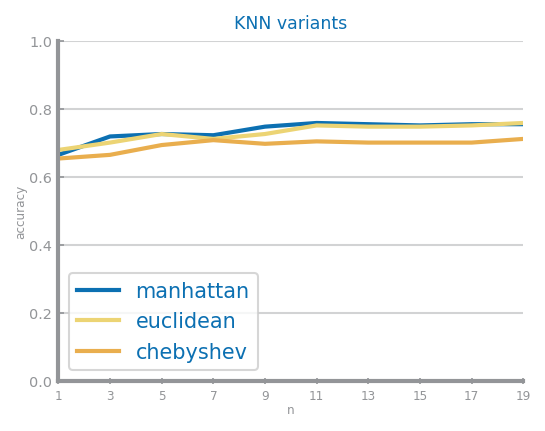

Best results with 11 neighbors and manhattan


In [15]:
nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
best = (0, '')
last_best = 0
for d in dist:
    yvalues = []
    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prdY = knn.predict(tstX)
        yvalues.append(metrics.accuracy_score(tstY, prdY))
        if yvalues[-1] > last_best:
            best = (n, d)
            last_best = yvalues[-1]
    values[d] = yvalues

plt.figure()
ds.multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
plt.savefig(project_path + '/images/finance_knn_study.png')
plt.show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

After the plot you can see the parameters for which the best results were achieved. So let's see its performance, in that context in terms of other metrics.

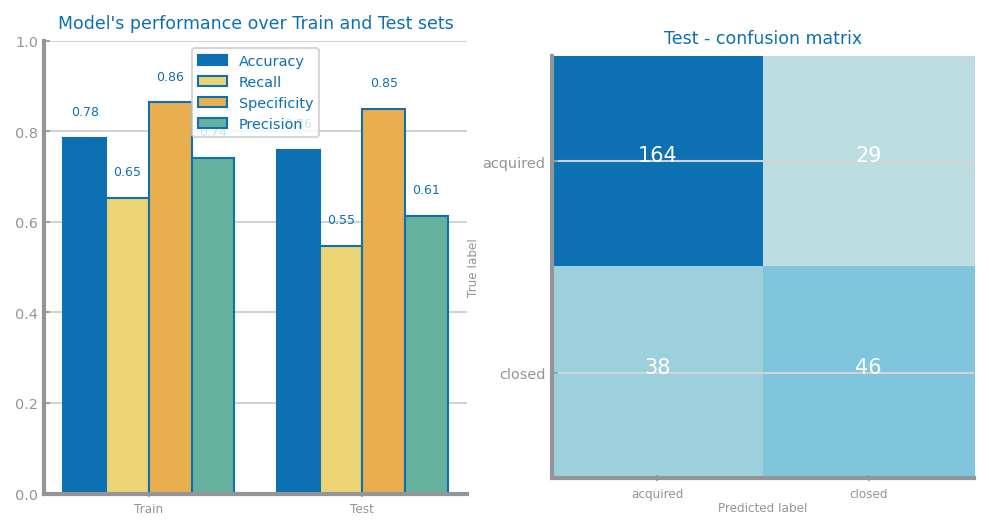

In [16]:
HEIGHT: int = 4
def plot_evaluation_results(labels: ndarray, trn_y, prd_trn, tst_y, prd_tst):
    cnf_mtx_trn = metrics.confusion_matrix(y_true=trn_y, y_pred=prd_trn, labels=labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(y_true=tst_y, y_pred=prd_tst, labels=labels)
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()

    evaluation = {'Accuracy': [(tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn),
                            (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)],
                'Recall': [tp_trn / (tp_trn + fn_trn), tp_tst / (tp_tst + fn_tst)],
                'Specificity': [tn_trn / (tn_trn + fp_trn), tn_tst / (tn_tst + fp_tst)],
                'Precision': [tp_trn / (tp_trn + fp_trn), tp_tst / (tp_tst + fp_tst)]}

    fig, axs = plt.subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
    ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets",
                    percentage=True)
    ds.plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[1], title='Test')

clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
plt.savefig(project_path + '/images/finance_knn_best.png')
plt.show()

## 02 - Naive Bayes
Naive Bayes is one of the most famous classification techniques, one of the most simplest ones, and the easiest to apply.

Like other Bayesian techniques, it just chooses the most probable class for each record, according to the estimation of the probability of each class given the record, whose label we want to predict. The trick and simplicity of Naive Bayes resides in the assumption of conditional independence among the variables, with simplifies that estimation and turns Naive Bayes as the standard baseline for classification.

Indeed, we can evaluate the performance of each classifier over a given dataset, simply by comparing their results among each other, in particular with the results of Naive Bayes over the dataset.

The nicest property of Naive Bayes is that it is not parametrizable, and so, its performance serves as a comparison baseline: any model is only interesting if it outperforms the one learnt through Naive Bayes.

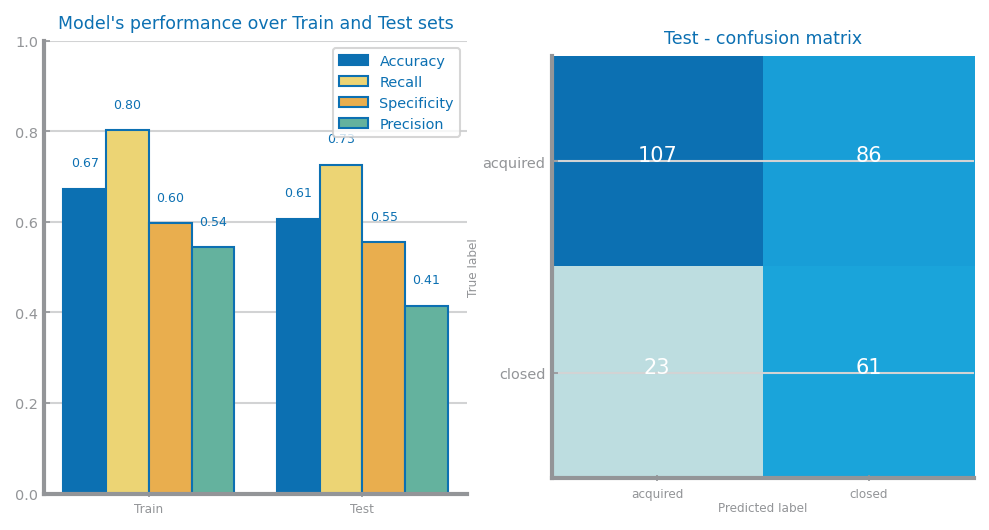

In [17]:
HEIGHT: int = 4
def plot_evaluation_results(labels: ndarray, trn_y, prd_trn, tst_y, prd_tst):
    cnf_mtx_trn = metrics.confusion_matrix(y_true=trn_y, y_pred=prd_trn, labels=labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(y_true=tst_y, y_pred=prd_tst, labels=labels)
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()

    evaluation = {'Accuracy': [(tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn),
                            (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)],
                'Recall': [tp_trn / (tp_trn + fn_trn), tp_tst / (tp_tst + fn_tst)],
                'Specificity': [tn_trn / (tn_trn + fp_trn), tn_tst / (tn_tst + fp_tst)],
                'Precision': [tp_trn / (tp_trn + fp_trn), tp_tst / (tp_tst + fp_tst)]}

    fig, axs = plt.subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
    ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets",
                    percentage=True)
    ds.plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[1], title='Test')

clf = GaussianNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
plt.savefig(project_path + '/images/finance_nb_best.png')
plt.show()

If we inspect the classes available in the sklearn.naive_bayes package, we see there are more then the GaussianNB estimators. Indeed, there are also the MultinomialNB and the BernoulliNB, that are adequate to use when the data distribution is close to be a multinomial or Bernoulli.

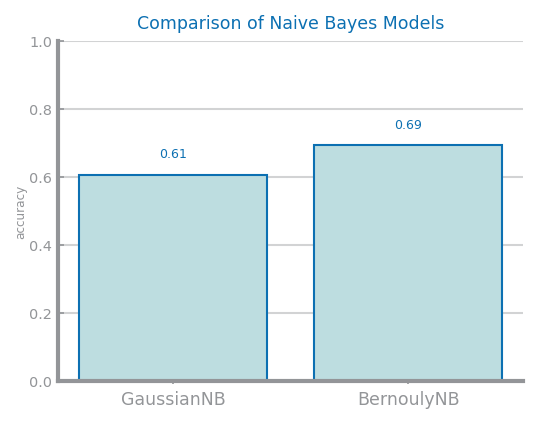

In [18]:
estimators = {'GaussianNB': GaussianNB(),
              #'MultinomialNB': MultinomialNB(),     NOT POSSIBLE TO RUN DUE TO THE EXISTENCE OF NEGATIVE VALUES
              'BernoulyNB': BernoulliNB()}

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(trnX, trnY)
    prdY = estimators[clf].predict(tstX)
    yvalues.append(metrics.accuracy_score(tstY, prdY))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.savefig(project_path + '/images/finance_nb_study.png')
plt.show()

## 03 - Decision Trees
Decision Trees are a friendly kind of model for classification, since they are interpretable and easy to apply. They are implemented in the DecisionTreeClassifier of sklearn.tree package.

In general, algorithms for training decision trees choose the best variable to split the dataset, in a manner that in each branch we will have a smaller mixture of classes. Then the algorithm repeats in the same way for each branch, until it reaches a pure leaf (a node with all the records of the same class) or there are no more variables to split the data.

The choice of the best variable is done according to a criterion: entropy and giny for implementing the information gain and giny impurity functions, respectively.

Among the several parameters, the max_depth determines the maximum size of the tree to reach, implementing a pre-pruning strategy. Other parameters with similar effects are the min_samples_leaf, min_samples_split and min_impurity_decrease thresholds, that avoid continuing growing the tree.

The min_impurity_decrease parameter implements the post-pruning strategy, since it only splits some node, if it brings more accuracy to the model.

<Figure size 600x450 with 0 Axes>

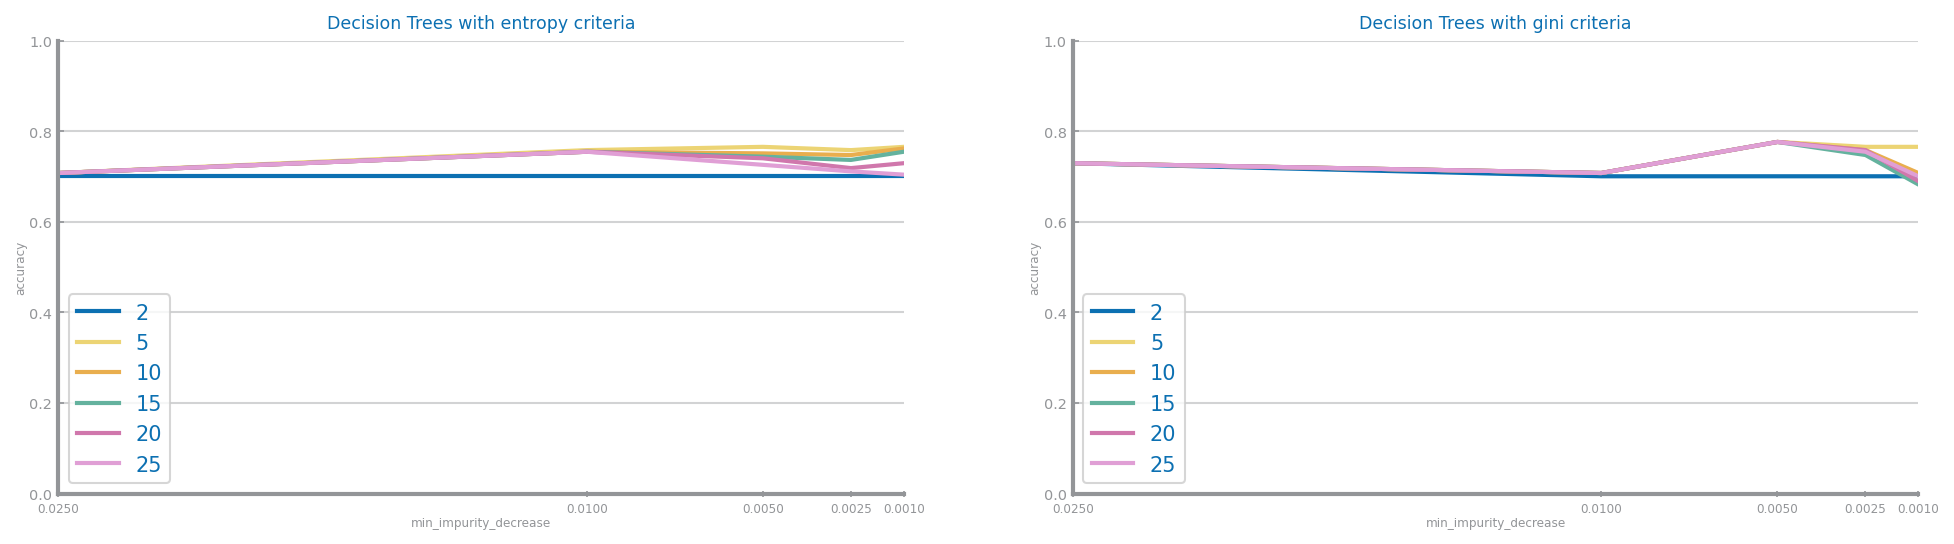

Best results achieved with gini criteria, depth=5 and min_impurity_decrease=0.0050 ==> accuracy=0.78


In [19]:
min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_tree = None

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        yvalues = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_tree = tree

        values[d] = yvalues
    ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title=f'Decision Trees with {f} criteria',
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)
plt.savefig(project_path + '/images/dt_study.png')
plt.show()
print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.4f ==> accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

In order to show the learned tree, we can use the graphviz package.

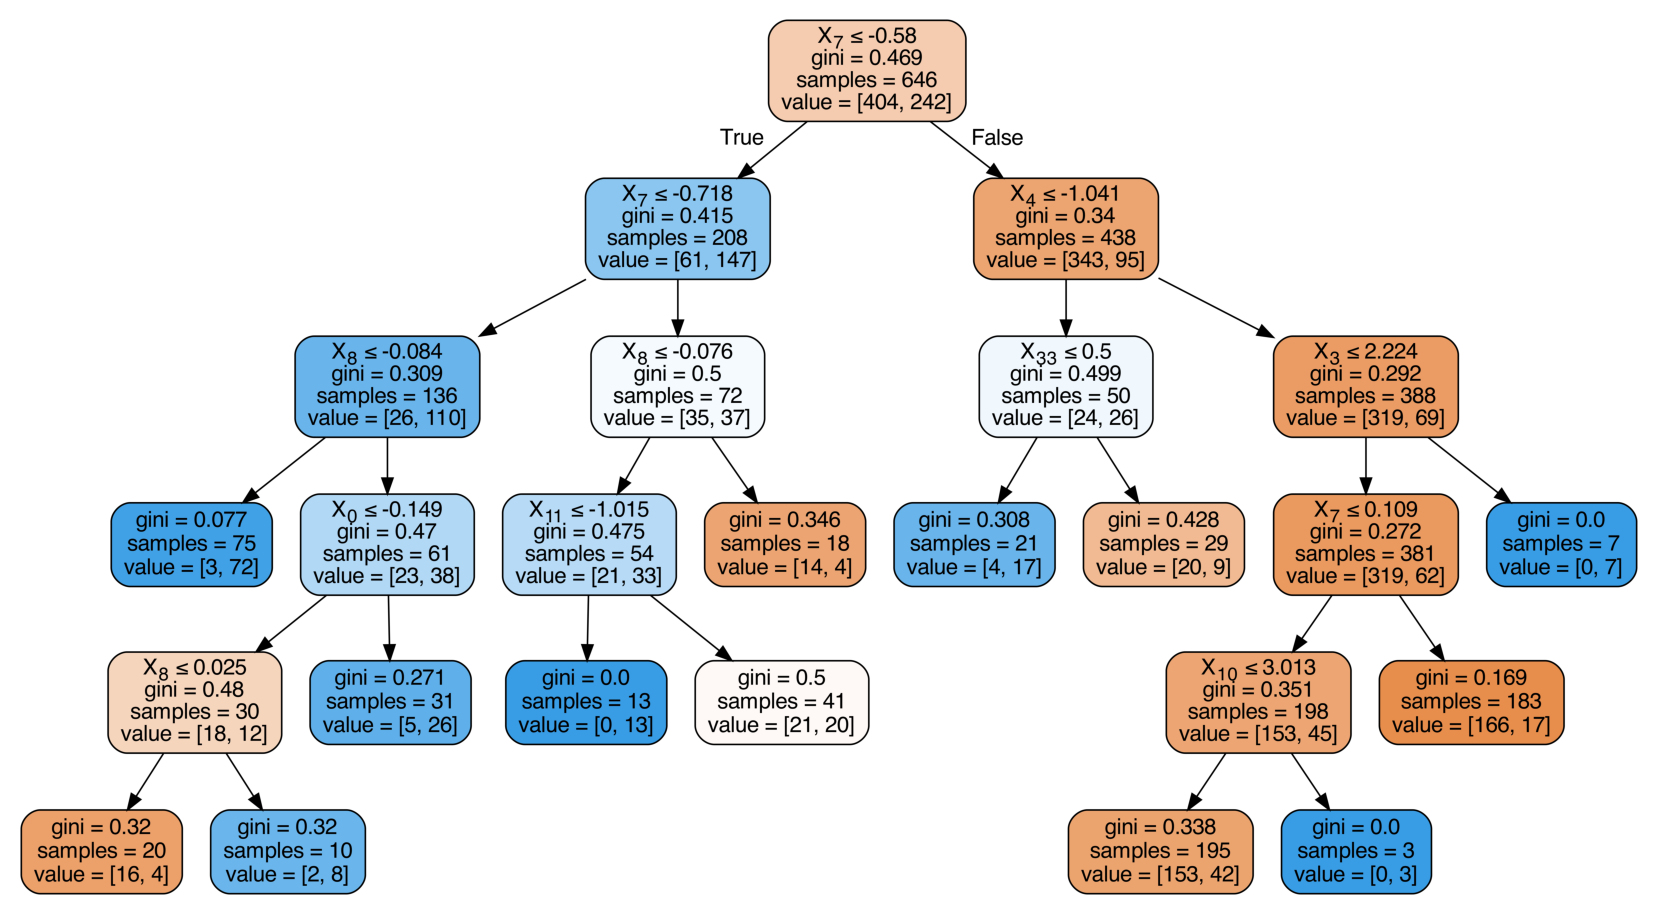

In [20]:
from sklearn.tree import export_graphviz

file_tree = 'best_tree.png'

dot_data = export_graphviz(best_tree, out_file='best_tree.dot', filled=True, rounded=True, special_characters=True)
# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'best_tree.dot', '-o', file_tree, '-Gdpi=600'])

plt.figure(figsize = (14, 18))
plt.imshow(plt.imread(file_tree))
plt.axis('off')
plt.show()

However, this is a very heavy image. In order to print a simpler version of the tree, we can just use:

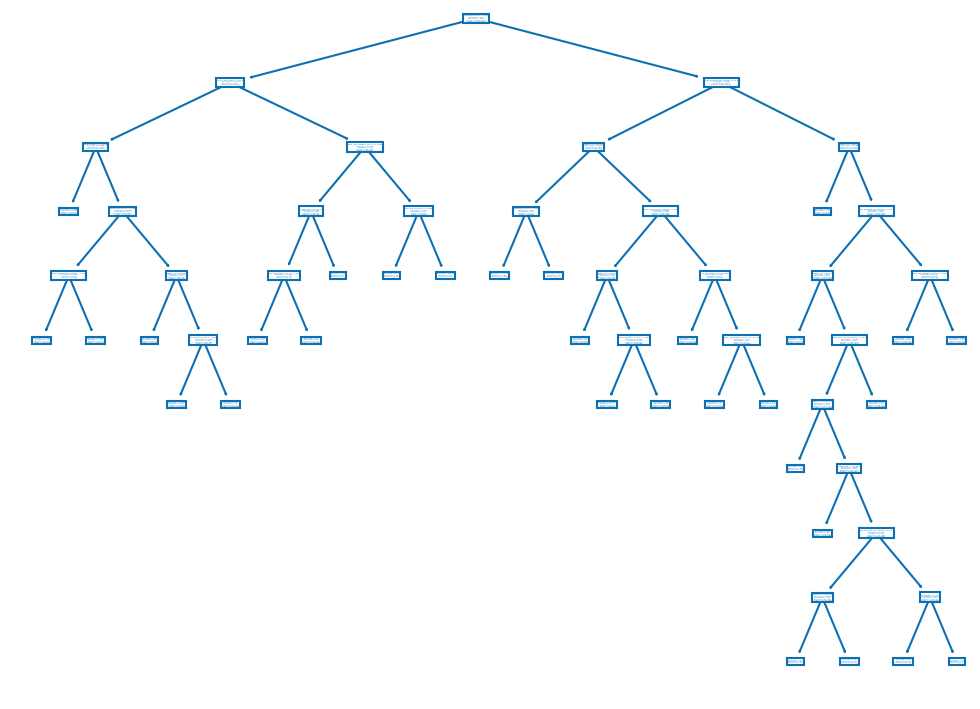

In [21]:
from sklearn import tree

tree.plot_tree(best_tree, feature_names=data_train_resplit.columns, class_names=labels.astype('str'))
plt.savefig(project_path + '/images/dt_best_tree.png')

In [22]:
def get_lineage(tree, feature_names):
     left      = tree.tree_.children_left
     right     = tree.tree_.children_right
     threshold = tree.tree_.threshold
     features  = [feature_names[i] for i in tree.tree_.feature]

     # get ids of child nodes
     idx = np.argwhere(left == -1)[:,0]     

     def recurse(left, right, child, lineage=None):          
          if lineage is None:
               lineage = [child]
          if child in left:
               parent = np.where(left == child)[0].item()
               split = 'l'
          else:
               parent = np.where(right == child)[0].item()
               split = 'r'

          lineage.append((parent, split, threshold[parent], features[parent]))

          if parent == 0:
               lineage.reverse()
               return lineage
          else:
               return recurse(left, right, parent, lineage)

     for child in idx:
          for node in recurse(left, right, child):
               print(node)

get_lineage(best_tree, data_train_resplit.columns)

(0, 'l', -0.5798429250717163, 'relationships')
(1, 'l', 39.0, 'years_until_end')
(2, 'l', -1.0150575637817383, 'milestones')
3
(0, 'l', -0.5798429250717163, 'relationships')
(1, 'l', 39.0, 'years_until_end')
(2, 'r', -1.0150575637817383, 'milestones')
(4, 'l', -0.7175490856170654, 'relationships')
(5, 'l', 5.5, 'last_funding_at_quarter')
6
(0, 'l', -0.5798429250717163, 'relationships')
(1, 'l', 39.0, 'years_until_end')
(2, 'r', -1.0150575637817383, 'milestones')
(4, 'l', -0.7175490856170654, 'relationships')
(5, 'r', 5.5, 'last_funding_at_quarter')
7
(0, 'l', -0.5798429250717163, 'relationships')
(1, 'l', 39.0, 'years_until_end')
(2, 'r', -1.0150575637817383, 'milestones')
(4, 'r', -0.7175490856170654, 'relationships')
(8, 'l', 2005.5, 'status')
9
(0, 'l', -0.5798429250717163, 'relationships')
(1, 'l', 39.0, 'years_until_end')
(2, 'r', -1.0150575637817383, 'milestones')
(4, 'r', -0.7175490856170654, 'relationships')
(8, 'r', 2005.5, 'status')
(10, 'l', 18.5, 'years_until_end')
11
(0, '

After the plot you can see the parameters for which the best results were achieved. So let's see its performance, in that context in terms of other metrics.

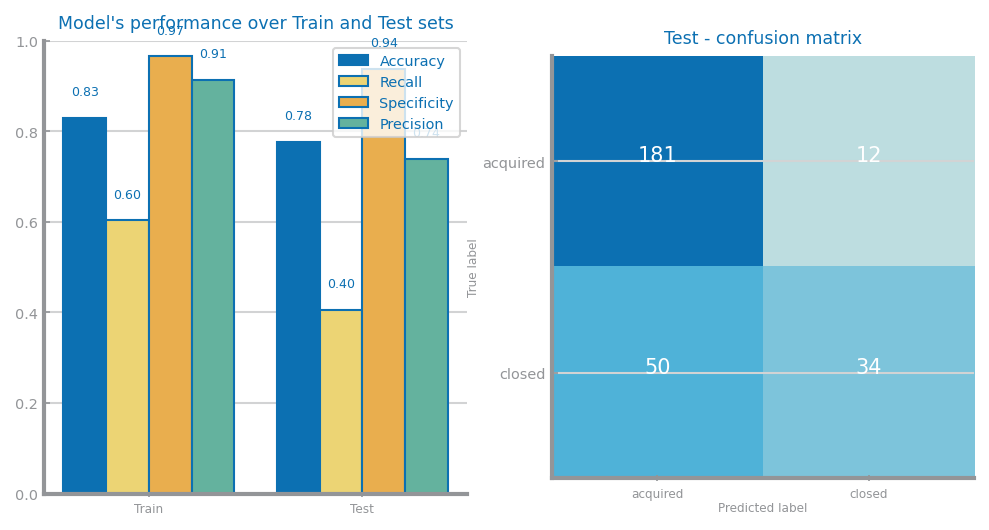

In [21]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
plt.savefig(project_path + '/images/dt_best.png')
plt.show()

## 04 - Random Forests
Random Forests, implemented through the RandomForestClassifier in the sklearn.ensemble package, are one of the most powerful classification technique, simple and easy to apply.

It trains a set of n decision trees, that are combined in an ensemble of n_estimators. Each tree, however, is trained over a different subset of the original training data, first by choosing a subset of k variables describing the data, with k determined by the max_features parameter. Beside many other parameters we can choose the maximum size of each tree, through the max_depth parameter.

Next, we can see the results achieved by a set of parameters combinations.

<Figure size 600x450 with 0 Axes>

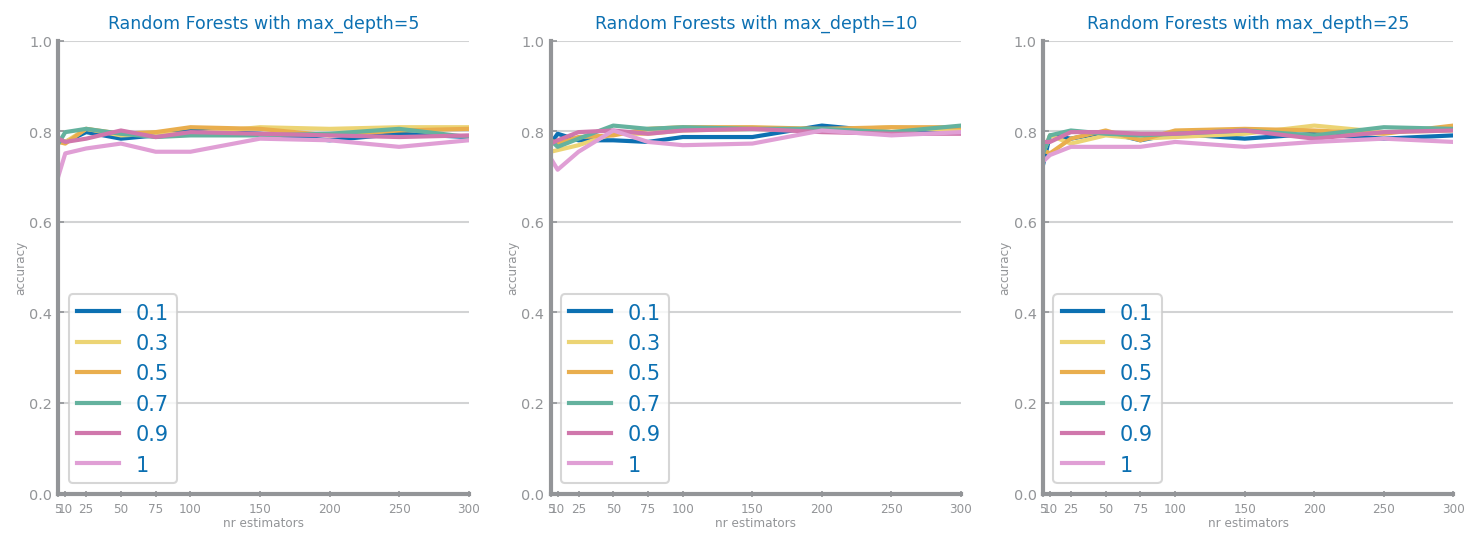

Best results with depth=10, 0.10 features and 200 estimators, with accuracy=0.81


In [22]:
n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best = ('', 0, 0)
last_best = 0
best_model = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_model = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title=f'Random Forests with max_depth={d}',
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
plt.savefig(project_path + 'images/finance_rf_study.png')
plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

After the plot you can see the parameters for which the best results were achieved. So let's see its performance, in that context in terms of other metrics.

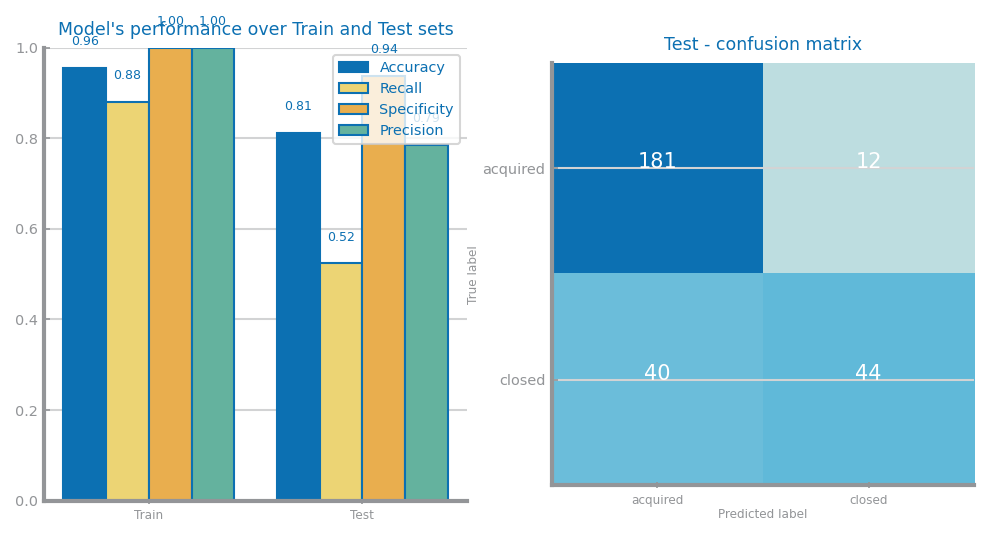

In [23]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
plt.savefig(project_path + 'images/finance_rf_best.png')
plt.show()

Random forests have the particularity of providing the importance of each variable in the global model. In order to reach those importances we just need to collect the feature_importances_ attribute from the learnt model as below.

1. feature relationships (0.13710908274884068)
2. feature age_last_milestone_year (0.08479728353741856)
3. feature funding_total_usd (0.07575272996433581)
4. feature age_last_funding_year (0.07273812155959808)
5. feature milestones (0.07116843156864279)
6. feature age_first_funding_year (0.0684948715143748)
7. feature avg_participants (0.060831638549938505)
8. feature age_first_milestone_year (0.05425286943759502)
9. feature longitude (0.05153355327220111)
10. feature Unnamed: 0 (0.051478452283094694)
11. feature latitude (0.05036629632999611)
12. feature is_top500 (0.038136059560418295)
13. feature funding_rounds (0.03223365093206877)
14. feature has_roundB (0.01472677435212777)
15. feature is_otherstate (0.012549468803132069)
16. feature has_roundC (0.012224878235076586)
17. feature has_roundA (0.010841092124129235)
18. feature is_othercategory (0.010827569276191834)
19. feature has_VC (0.010429660929501781)
20. feature is_CA (0.007939441463917755)
21. feature is_software (0.00787166

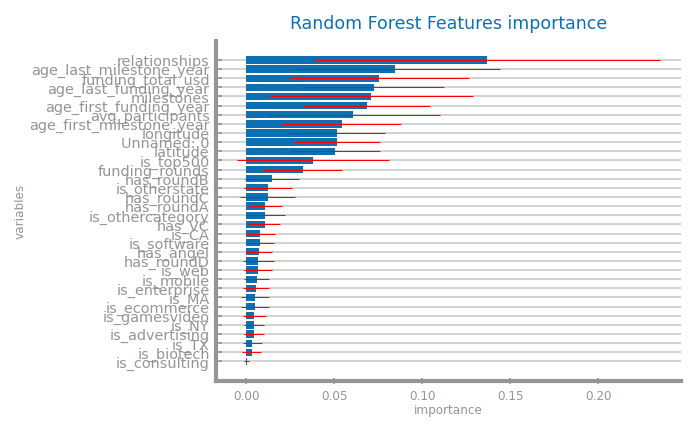

In [24]:
variables = x_train.columns
importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
elems = []
for f in range(trnX.shape[1]):
    elems += [variables[indices[f]]]
    print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

plt.figure()
ds.horizontal_bar_chart(elems, importances[indices], std[indices], title='Random Forest Features importance', xlabel='importance', ylabel='variables')
plt.savefig(project_path + 'images/finance_rf_ranking.png')

## 05 - Gradient Boosting
Gradient Boosting, implemented through the GradientBoostingClassifier in the sklearn.ensemble package, is anoother powerful classification technique.

Like random forests, it trains a set of n decision trees, that are combined in an ensemble of n_estimators. Each tree, however, is trained over the original dataset and usually has a fixed maximum depth. Beside many other parameters we can choose the maximum tree depth, through the max_depth parameter and the learning rate to use, through the learning_rate parameter.

Next, we can see the results achieved by a set of parameters combinations.

<Figure size 600x450 with 0 Axes>

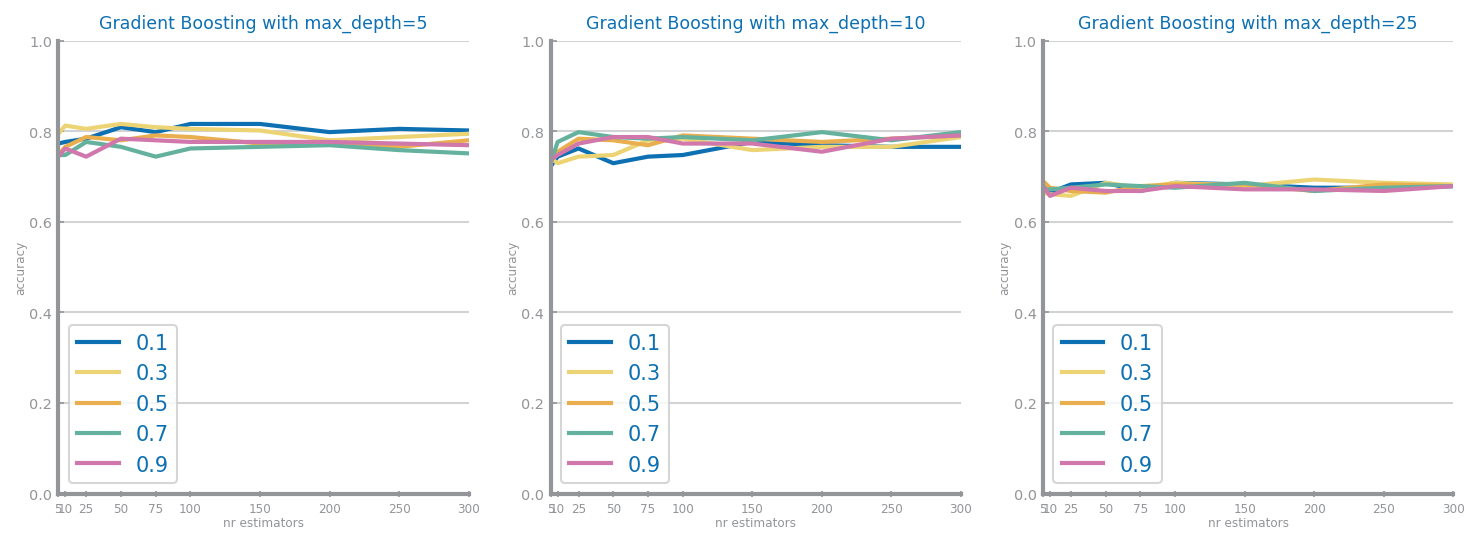

Best results with depth=5, learning rate=0.10 and 100 estimators, with accuracy=0.82


In [25]:
n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 25]
learning_rate = [.1, .3, .5, .7, .9]
best = ('', 0, 0)
last_best = 0
best_tree = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for lr in learning_rate:
        yvalues = []
        for n in n_estimators:
            gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
            gb.fit(trnX, trnY)
            prdY = gb.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, lr, n)
                last_best = yvalues[-1]
                best_tree = gb
        values[lr] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title=f'Gradient Boosting with max_depth={d}',
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
plt.savefig(project_path + 'images/finance_gb_study.png')
plt.show()
print('Best results with depth=%d, learning rate=%1.2f and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

After the plot you can see the parameters for which the best results were achieved. So let's see its performance, in that context in terms of other metrics.

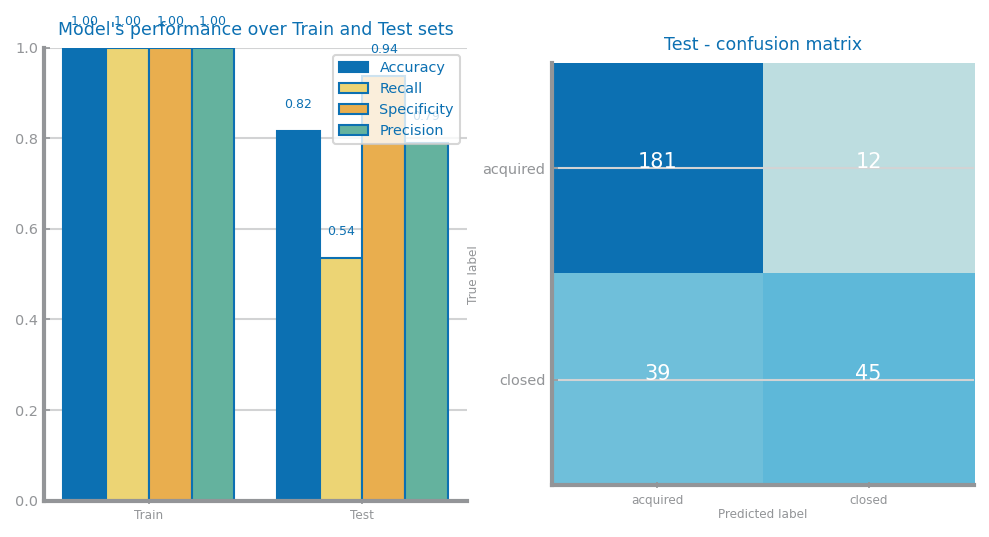

In [26]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
plt.savefig(project_path + 'images/finance_gb_best.png')
plt.show()

## 06 - Neural Network (Multi Layer Perceptron - MLP)
Multi Layer Perceptrons are the usual representation used by neural networks for dealing with multidimensional data. In Python they are implemented through the MLPClassifier in the sklearn.neural_network.

Its training is done through an implementation of the backpropagation algorithm, and so it makes use of a learning rate specified through the learning_rate_init parameter, a number of maximum iterations (max_iter parameter) and the kind of learning rate change through the learning_rate parameter. trains a set of n decision trees, that are combined in an ensemble of n_estimators. Beside those, we also may choose among different activation functions through the activation parameter here instantiated as the logistic function. Setting the verbose parameter we are able to see the error evolution along iterations.

<Figure size 600x450 with 0 Axes>

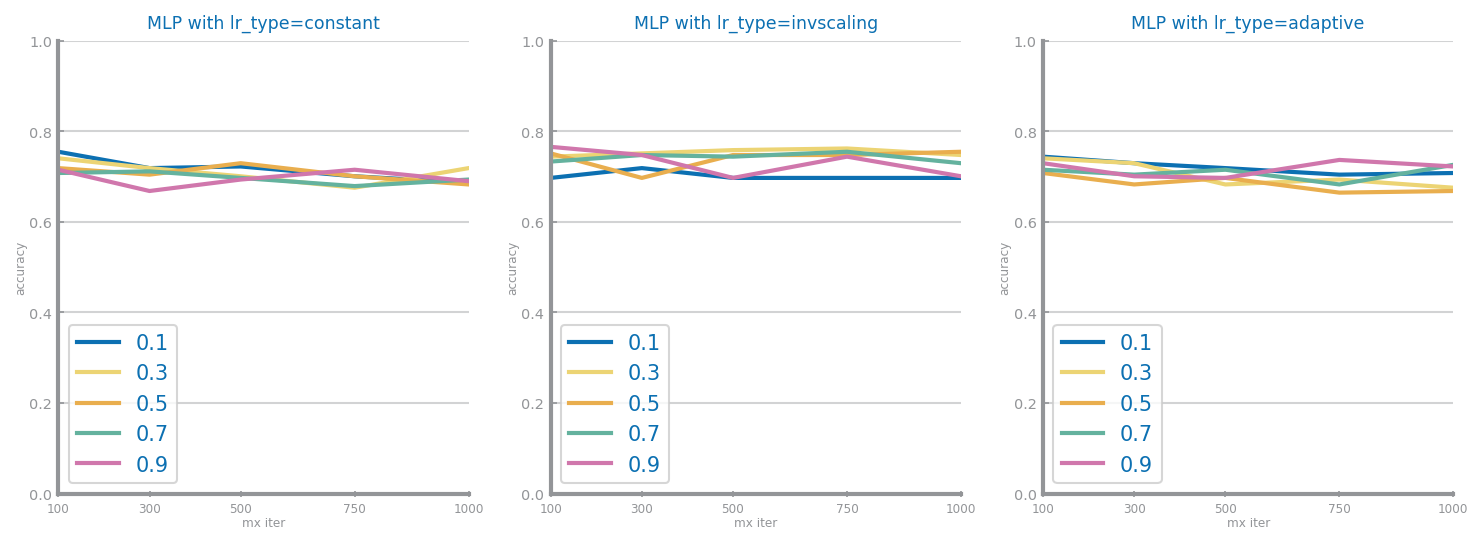

Best results with lr_type=invscaling, learning rate=0.9 and 100 max iter, with accuracy=0.7653429602888087


In [27]:
lr_type = ['constant', 'invscaling', 'adaptive']
max_iter = [100, 300, 500, 750, 1000]
learning_rate = [.1, .3, .5, .7, .9]
best = ('', 0, 0)
last_best = 0
best_model = None

cols = len(lr_type)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(lr_type)):
    d = lr_type[k]
    values = {}
    for lr in learning_rate:
        yvalues = []
        for n in max_iter:
            mlp = MLPClassifier(activation='logistic', solver='sgd', learning_rate=d,
                                learning_rate_init=lr, max_iter=n, verbose=False)
            mlp.fit(trnX, trnY)
            prdY = mlp.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (d, lr, n)
                last_best = yvalues[-1]
                best_model = mlp
        values[lr] = yvalues
    ds.multiple_line_chart(max_iter, values, ax=axs[0, k], title=f'MLP with lr_type={d}',
                           xlabel='mx iter', ylabel='accuracy', percentage=True)
plt.savefig(project_path + 'images/finance_mlp_study.png')
plt.show()
print(f'Best results with lr_type={best[0]}, learning rate={best[1]} and {best[2]} max iter, with accuracy={last_best}')

After the plot you can see the parameters for which the best results were achieved. So let's see its performance, in that context in terms of other metrics.

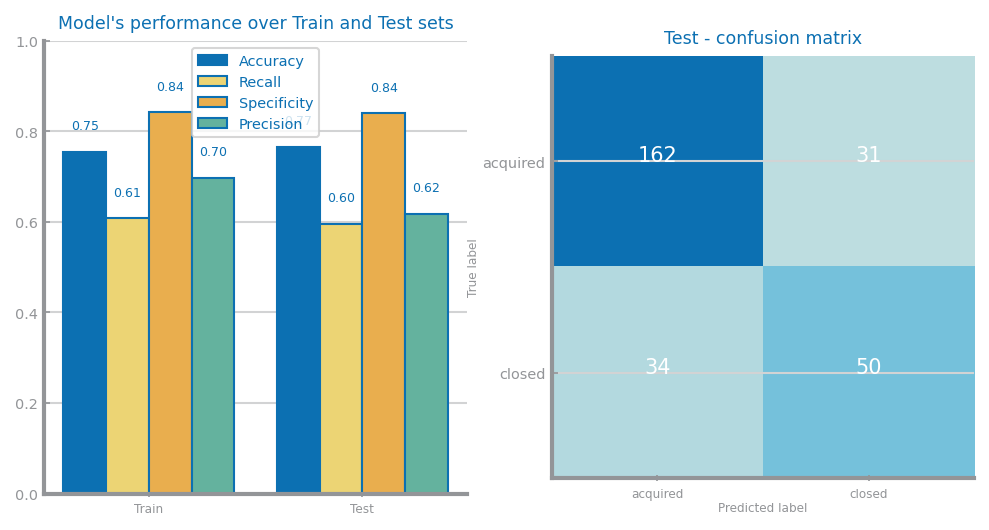

In [28]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
plt.savefig(project_path + 'images/finance_mlp_best.png')
plt.show()